# Softmin Discrete Minimax Classifer for Imbalanced Datasets and Prior Probability Shifts

#### References for these algorithms:
Article [1]: *Discrete Box-Constrained Minimax Classifier for Uncertain and Imbalanced Class Proportions.* Cyprien Gilet, Susana Barbosa, Lionel Fillatre, IEEE TRANSACTIONS ON PATTERN ANALYSIS AND MACHINE INTELLIGENCE, 2020.

Article [2]: *Adjusting Decision Trees for Uncertain Class Proportions.* Cyprien Gilet, Marie Guyomard, Susana Barbosa, Lionel Fillatre, ECML/PKDD Workshop on Uncertainty in Machine Learning (WUML), 2020.

Article [3]: *Softmin Discrete Minimax Classifier for Imbalanced Classes and Prior Probability Shifts.* Cyprien Gilet, Marie Guyomard, Sébastien Destercke, Lionel Fillatre, available soon, 2023.

The authors sincerely thank Marie Guyomard for her contributions and her precious help in this project.

## Script Diabete Database

In [1]:
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
import random
import seaborn as sn
import time
from scipy.spatial import Voronoi, voronoi_plot_2d
from matplotlib.colors import LinearSegmentedColormap
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import kneighbors_graph
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from scipy.io import loadmat

np.random.seed(407)

#### Call the notebook "DMC_functions.ipynb" containing all the functions

In [2]:
run DMC_functions.ipynb

### Import Database

In [3]:
data = loadmat('Diabetes37_data.mat')
data.keys()

X = pd.DataFrame(data['X'])
YR = pd.DataFrame(data['YR'], columns = ['y'])

K = int(data['K'][0][0])
L = np.ones((K,K)) - np.eye(K)

### Cross-Validation Procedure

In [4]:
nbFolds = 3

depth = [3,4,5] #List of maximal depth of the Decision Tree to be tested in order to achieve an acceptable generalization error.
nbFoldsfitT = 2 #Number of iterations of the sub-cross-validation procedure on the training set for selecting the optimal number of centroids in order to achieve an acceptable generalization error.
epsT = 0.1 #Maximum gap between the global risks of error of the training set and the generalization error.
N = 10000 #Number of iterations for the projected subgradient algorithm for computing piStar.
optionPlot = 0 #Allows to plot the convergence of the projected subgradient algorithm and the Fig. 2 on the paper regarding the choic of the optimal number of centroids.

# Parameters for SoftminDMC
lambd = 120
eps_Softmin = 0.00001
N_Softmin = 50000
Alpha = np.ones((1,K))[0]

In [5]:
# Stockage variable Weighted Logistic Regression
stock_rTrain_WLR = []
stock_rTest_WLR = []
stock_RTrain_WLR = []
stock_RTest_WLR = []
stock_psi_Train_WLR = []
stock_psi_Test_WLR = []
time_Train_WLR = []
time_Test_WLR = []

# Stockage variable Weighted Decision Tree
stock_rTrain_WDT = []
stock_rTest_WDT = []
stock_RTrain_WDT = []
stock_RTest_WDT = []
stock_psi_Train_WDT = []
stock_psi_Test_WDT = []
time_Train_WDT = []
time_Test_WDT = []

# Stockage variable DMC
stock_rTrain_DMC = []
stock_rTest_DMC = []
stock_RTrain_DMC = []
stock_RTest_DMC = []
stock_psi_Train_DMC = []
stock_psi_Test_DMC = []
stock_pibar = pd.DataFrame(columns=range(K), index=range(nbFolds))
time_Train_DMC = []
time_Test_DMC = []

# Stockage variable SoftminDMC
stock_rTrain_SoftminDMC = []
stock_rTest_SoftminDMC = []
stock_RTrain_SoftminDMC = []
stock_RTest_SoftminDMC = []
stock_psi_Train_SoftminDMC = []
stock_psi_Test_SoftminDMC = []
stock_piStar = pd.DataFrame(columns=range(K), index=range(nbFolds))
time_Train_SoftminDMC = []
time_Test_SoftminDMC = []

In [6]:
nbpiTest = 1000
stock_r_WLR_test_shift = np.zeros((nbFolds,nbpiTest))
stock_R_WLR_test_shift = np.zeros((nbFolds,nbpiTest,K))

stock_r_WDT_test_shift = np.zeros((nbFolds,nbpiTest))
stock_R_WDT_test_shift = np.zeros((nbFolds,nbpiTest,K))

stock_r_DMC_test_shift = np.zeros((nbFolds,nbpiTest))
stock_R_DMC_test_shift = np.zeros((nbFolds,nbpiTest,K))

stock_r_SoftminDMC_test_shift = np.zeros((nbFolds,nbpiTest))
stock_R_SoftminDMC_test_shift = np.zeros((nbFolds,nbpiTest,K))

In [7]:
###############################   CROSS VALIDATION   ##########################
checkProp = 0
while checkProp < nbFolds:
    checkProp = 0
    kf = KFold(n_splits=nbFolds, shuffle=True, random_state=True)
    kfSplit = kf.split(X)
    for train, test in kf.split(X):
        XTrain, XTest, YRTrain, YRTest = X.loc[train,:], X.loc[test,:], YR.loc[train,:], YR.loc[test,:]
        Xtrain = XTrain.reset_index()
        Xtrain.drop(['index'], axis='columns', inplace=True)
        Xtest = XTest.reset_index()
        Xtest.drop(['index'], axis='columns', inplace=True)
        YRtrain = YRTrain.reset_index()
        YRtrain.drop(['index'], axis='columns', inplace=True)
        YRtest = YRTest.reset_index()
        YRtest.drop(['index'], axis='columns', inplace=True)

        # Compute the proportions
        piTest = compute_pi(K, YRtest)
        print(piTest)
        if piTest[0,1] >= 0.006:
            checkProp = checkProp + 1
    
    print(checkProp)


f=0
kf = KFold(n_splits=nbFolds)
for train, test in kfSplit:
    print("processing fold f =", f) 
    XTrain, XTest, YRTrain, YRTest = X.loc[train,:], X.loc[test,:], YR.loc[train,:], YR.loc[test,:]
    Xtrain = XTrain.reset_index()
    Xtrain_index = pd.DataFrame({'index_new' : list(range(Xtrain.shape[0])), 'index_old':Xtrain['index'].tolist()})
    Xtrain.drop(['index'], axis='columns', inplace=True)
    Xtest = XTest.reset_index()
    Xtest_index = pd.DataFrame({'index_new' : list(range(Xtest.shape[0])), 'index_old':Xtest['index'].tolist()})
    Xtest.drop(['index'], axis='columns', inplace=True)
    YRtrain = YRTrain.reset_index()
    YRtrain_index = pd.DataFrame({'index_new' : list(range(YRtrain.shape[0])), 'index_old':YRtrain['index'].tolist()})
    YRtrain.drop(['index'], axis='columns', inplace=True)
    YRtest = YRTest.reset_index()
    YRtest_index = pd.DataFrame({'index_new' : list(range(YRtest.shape[0])), 'index_old':YRtest['index'].tolist()})
    YRtest.drop(['index'], axis='columns', inplace=True)

    
    piTest = compute_pi(K, YRtest)
    piTrain = compute_pi(K, YRtrain)
    
    
    
    ### Weighted Logistic Regression
    print("    WLR...")
    start_time = time.time()
    model_WLR = LogisticRegression(penalty='none', solver='saga', multi_class='multinomial', C=1, class_weight='balanced',max_iter=10000)
    model_WLR.fit(Xtrain,YRtrain.values.ravel())
    time_Train_WLR.append(time.time() - start_time)
    # Prediction on the training sample
    YhatTrainWLR = model_WLR.predict(Xtrain)
    RWLR_Train, confmatTrainWLR = compute_conditional_risk(YRtrain, YhatTrainWLR, K, L)
    rWLR_Train = compute_global_risk(RWLR_Train, piTrain)
    stock_rTrain_WLR.append(rWLR_Train)
    stock_RTrain_WLR.append(RWLR_Train)
    stock_psi_Train_WLR.append(np.max(RWLR_Train[0])-np.min(RWLR_Train[0]))
    # Test on the testing sample
    start_time = time.time()
    YhatTestWLR = model_WLR.predict(Xtest)
    time_Test_WLR.append(time.time() - start_time)
    RWLR_Test, confmatTestWLR = compute_conditional_risk(YRtest, YhatTestWLR, K, L)
    rWLR_Test = compute_global_risk(RWLR_Test, piTest)
    stock_rTest_WLR.append(rWLR_Test)
    stock_RTest_WLR.append(RWLR_Test)
    stock_psi_Test_WLR.append(np.max(RWLR_Test[0])-np.min(RWLR_Test[0]))
    
    
    
    ### Weighted Decision Tree
    print("    WDT...")
    start_time = time.time()
    model_WDT = DecisionTreeClassifier(random_state=0, max_depth=3, class_weight='balanced')
    model_WDT.fit(Xtrain,YRtrain.values.ravel())
    time_Train_WDT.append(time.time() - start_time)
    # Prediction on the training sample
    YhatTrainWDT = model_WDT.predict(Xtrain)
    RWDT_Train, confmatTrainWDT = compute_conditional_risk(YRtrain, YhatTrainWDT, K, L)
    rWDT_Train = compute_global_risk(RWDT_Train, piTrain)
    stock_rTrain_WDT.append(rWDT_Train)
    stock_RTrain_WDT.append(RWDT_Train)
    stock_psi_Train_WDT.append(np.max(RWDT_Train[0])-np.min(RWDT_Train[0]))
    # Test on the testing sample
    start_time = time.time()
    YhatTestWDT = model_WDT.predict(Xtest)
    time_Test_WDT.append(time.time() - start_time)
    RWDT_Test, confmatTestWDT = compute_conditional_risk(YRtest, YhatTestWDT, K, L)
    rWDT_Test = compute_global_risk(RWDT_Test, piTest)
    stock_rTest_WDT.append(rWDT_Test)
    stock_RTest_WDT.append(RWDT_Test)
    stock_psi_Test_WDT.append(np.max(RWDT_Test[0])-np.min(RWDT_Test[0]))
    
    
    
    ### DMC
    print("    DMC...")
    start_time = time.time()
    #piBarDMC, pHat, kmeansDMC, V_iterDMC, T_opt_DMC = fit_DMC(Xtrain, YRtrain, K, L, 'kmeans', [nbFoldsfitT, nbT, optionPlot, T_max], None, N, epsT, 'none')
    piBarDMC, pHat, discretization_DT, V_iterDMC, T_opt_DMC = fit_DMC(Xtrain, YRtrain, K, L,'DT', None, [depth, nbFoldsfitT, optionPlot], N, epsT, 'none')
    time_Train_DMC.append(time.time() - start_time)
    for k in range(K):
        stock_pibar.loc[f, k] = piBarDMC[0][k]      
    # Prediction on the training sample
    YhatTrainDMC = predict_DMC(Xtrain, K, L, 'DT', discretization_DT, pHat, piBarDMC)
    R_DMC_Train, confmatTrainDMC = compute_conditional_risk(YRtrain, YhatTrainDMC, K, L)
    r_DMC_Train = compute_global_risk(R_DMC_Train, piTrain)
    stock_rTrain_DMC.append(r_DMC_Train)
    stock_RTrain_DMC.append(R_DMC_Train)
    stock_psi_Train_DMC.append(np.max(R_DMC_Train[0])-np.min(R_DMC_Train[0]))   
    # Prediction on the testing sample
    start_time = time.time()
    YhatTestDMC = predict_DMC(Xtest, K, L, 'DT', discretization_DT, pHat, piBarDMC)
    time_Test_DMC.append(time.time() - start_time)
    R_DMC_Test, confmatTestDMC = compute_conditional_risk(YRtest, YhatTestDMC, K, L)
    r_DMC_Test = compute_global_risk(R_DMC_Test, piTest)
    stock_rTest_DMC.append(r_DMC_Test)
    stock_RTest_DMC.append(R_DMC_Test)
    stock_psi_Test_DMC.append(np.max(R_DMC_Test[0])-np.min(R_DMC_Test[0]))
    
    
    
    ### Softmin-DMC
    print("    Softmin-DMC...")
    start_time = time.time()
    
    # --- Optimization with Monte-Carlo Algorithm:
    piStar = SoftminDMC_compute_G_root_MonteCarlo(K, L, pHat, lambd, N_Softmin, Alpha, eps_Softmin)
    
    # --- Optimization with Ascent-Step Algorithm:
    #piStar = SoftminDMC_compute_G_root_ascent_Step(K, L, pHat, lambd, N_Softmin, eps_Softmin)
    
    time_Train_SoftminDMC.append(time.time() - start_time)
    for k in range(K):
        stock_piStar.loc[f, k] = piStar[0][k]      
    # Prediction on the training sample
    YhatTrainSoftminDMC, OutputProbaSoftminDMC_train = SoftminDMC_predict(Xtrain, K, L, 'DT', discretization_DT, pHat, piStar, lambd)
    R_SoftminDMC_Train, confmatTrainSoftminDMC = compute_conditional_risk(YRtrain, YhatTrainSoftminDMC, K, L)
    r_SoftminDMC_Train = compute_global_risk(R_SoftminDMC_Train, piTrain)
    stock_rTrain_SoftminDMC.append(r_SoftminDMC_Train)
    stock_RTrain_SoftminDMC.append(R_SoftminDMC_Train)
    stock_psi_Train_SoftminDMC.append(np.max(R_SoftminDMC_Train[0])-np.min(R_SoftminDMC_Train[0]))   
    # Prediction on the testing sample
    start_time = time.time()
    YhatTestSoftminDMC, OutputProbaSoftminDMC_test = SoftminDMC_predict(Xtest, K, L, 'DT', discretization_DT, pHat, piStar, lambd)
    time_Test_SoftminDMC.append(time.time() - start_time)
    R_SoftminDMC_Test, confmatTestSoftminDMC = compute_conditional_risk(YRtest, YhatTestSoftminDMC, K, L)
    r_SoftminDMC_Test = compute_global_risk(R_SoftminDMC_Test, piTest)
    stock_rTest_SoftminDMC.append(r_SoftminDMC_Test)
    stock_RTest_SoftminDMC.append(R_SoftminDMC_Test)
    stock_psi_Test_SoftminDMC.append(np.max(R_SoftminDMC_Test[0])-np.min(R_SoftminDMC_Test[0]))
    
    f+=1 
    

[[0.640625 0.359375]]
[[0.67578125 0.32421875]]
[[0.63671875 0.36328125]]
3
processing fold f = 0
    WLR...
    WDT...
    DMC...
Fit DMC ...
-> Search of the optimal depth:
---> Sub-cross-validation procedure: Processing fold f = 0
------> Processing depth = 3
------> Processing depth = 4
------> Processing depth = 5
---> Sub-cross-validation procedure: Processing fold f = 1
------> Processing depth = 3
------> Processing depth = 4
------> Processing depth = 5
-> Warning: there is no depth achieving abs(rTrain - rTest) < eps
-> Optimal Depth (with respect to epsT) = 3
-> Compute the least favorable priors piStar
    Softmin-DMC...
At iteration n = 1
----> normGpiStar = 0.2848476508657254
At iteration n = 4
----> normGpiStar = 0.2835553653791339
At iteration n = 5
----> normGpiStar = 0.2627670751637509
At iteration n = 6
----> normGpiStar = 0.23828011381904837
At iteration n = 16
----> normGpiStar = 0.2141802016441423
At iteration n = 31
----> normGpiStar = 0.12427166521553538
At iter

 Average results: Weighted Logistic Regression

In [8]:
# Weighted Logistic Regression   
AV_rTrain_WLR = np.mean(stock_rTrain_WLR)   
STD_rTrain_WLR = np.std(stock_rTrain_WLR)    
 
AV_rTest_WLR = np.mean(stock_rTest_WLR) 
STD_rTest_WLR = np.std(stock_rTest_WLR)  
     
AV_RTrain_WLR = np.mean(stock_RTrain_WLR, axis=0)
AV_RTest_WLR = np.mean(stock_RTest_WLR, axis=0)

RmaxTrain_WLR = []
RmaxTest_WLR = []
for f in range(nbFolds):
    RmaxTrain_WLR.append(np.max(stock_RTrain_WLR[f]))
    RmaxTest_WLR.append(np.max(stock_RTest_WLR[f]))
AV_RmaxTrain_WLR = np.mean(RmaxTrain_WLR)
STD_RmaxTrain_WLR = np.std(RmaxTrain_WLR)
AV_RmaxTest_WLR = np.mean(RmaxTest_WLR)
STD_RmaxTest_WLR = np.std(RmaxTest_WLR)

AV_psi_Train_WLR = np.mean(stock_psi_Train_WLR, axis=0)
STD_psi_Train_WLR = np.std(stock_psi_Train_WLR, axis=0)

AV_psi_Test_WLR = np.mean(stock_psi_Test_WLR, axis=0)
STD_psi_Test_WLR = np.std(stock_psi_Test_WLR, axis=0)

AV_time_Train_WLR = np.mean(time_Train_WLR, axis=0)
STD_time_Train_WLR = np.std(time_Train_WLR, axis=0)

AV_time_Test_WLR = np.mean(time_Test_WLR, axis=0)
STD_time_Test_WLR = np.std(time_Test_WLR, axis=0)

 Average results: Weighted Random Forest 

In [9]:
# Weighted Decision Tree  
AV_rTrain_WDT = np.mean(stock_rTrain_WDT) 
STD_rTrain_WDT = np.std(stock_rTrain_WDT)   
   
AV_rTest_WDT = np.mean(stock_rTest_WDT)    
STD_rTest_WDT = np.std(stock_rTest_WDT)  
  
AV_RTrain_WDT = np.mean(stock_RTrain_WDT, axis=0)
AV_RTest_WDT = np.mean(stock_RTest_WDT, axis=0)

RmaxTrain_WDT = []
RmaxTest_WDT = []
for f in range(nbFolds):
    RmaxTrain_WDT.append(np.max(stock_RTrain_WDT[f]))
    RmaxTest_WDT.append(np.max(stock_RTest_WDT[f]))
AV_RmaxTrain_WDT = np.mean(RmaxTrain_WDT)
STD_RmaxTrain_WDT = np.std(RmaxTrain_WDT)
AV_RmaxTest_WDT = np.mean(RmaxTest_WDT)
STD_RmaxTest_WDT = np.std(RmaxTest_WDT)

AV_psi_Train_WDT = np.mean(stock_psi_Train_WDT, axis=0)
STD_psi_Train_WDT = np.std(stock_psi_Train_WDT, axis=0)

AV_psi_Test_WDT = np.mean(stock_psi_Test_WDT, axis=0)
STD_psi_Test_WDT = np.std(stock_psi_Test_WDT, axis=0)

AV_time_Train_WDT = np.mean(time_Train_WDT, axis=0)
STD_time_Train_WDT = np.std(time_Train_WDT, axis=0)

AV_time_Test_WDT = np.mean(time_Test_WDT, axis=0)
STD_time_Test_WDT = np.std(time_Test_WDT, axis=0)

 Average results: Discrete Minimax Classifier

In [10]:
# DMC
AV_piBar = stock_pibar.mean(axis=0)
AV_rTrain_DMC = np.mean(stock_rTrain_DMC) 
STD_rTrain_DMC = np.std(stock_rTrain_DMC)    
   
AV_rTest_DMC = np.mean(stock_rTest_DMC) 
STD_rTest_DMC = np.std(stock_rTest_DMC) 
   
AV_RTrain_DMC = np.mean(stock_RTrain_DMC, axis=0)    
AV_RTest_DMC = np.mean(stock_RTest_DMC, axis=0)  

RmaxTrain_DMC = []
RmaxTest_DMC = []
for f in range(nbFolds):
    RmaxTrain_DMC.append(np.max(stock_RTrain_DMC[f]))
    RmaxTest_DMC.append(np.max(stock_RTest_DMC[f]))
AV_RmaxTrain_DMC = np.mean(RmaxTrain_DMC)
STD_RmaxTrain_DMC = np.std(RmaxTrain_DMC)
AV_RmaxTest_DMC = np.mean(RmaxTest_DMC)
STD_RmaxTest_DMC = np.std(RmaxTest_DMC) 

AV_psi_Train_DMC = np.mean(stock_psi_Train_DMC, axis=0)
STD_psi_Train_DMC = np.std(stock_psi_Train_DMC, axis=0)

AV_psi_Test_DMC = np.mean(stock_psi_Test_DMC, axis=0)   
STD_psi_Test_DMC = np.std(stock_psi_Test_DMC, axis=0) 
 
AV_time_Train_DMC = np.mean(time_Train_DMC, axis=0)
STD_time_Train_DMC = np.std(time_Train_DMC, axis=0)

AV_time_Test_DMC = np.mean(time_Test_DMC, axis=0) 
STD_time_Test_DMC = np.std(time_Test_DMC, axis=0) 

 Average results: Softmin Discrete Minimax Classifier

In [11]:
# Softmin-DMC
AV_piStar = stock_piStar.mean(axis=0)
AV_rTrain_SoftminDMC = np.mean(stock_rTrain_SoftminDMC) 
STD_rTrain_SoftminDMC = np.std(stock_rTrain_SoftminDMC)    
   
AV_rTest_SoftminDMC = np.mean(stock_rTest_SoftminDMC) 
STD_rTest_SoftminDMC = np.std(stock_rTest_SoftminDMC) 
   
AV_RTrain_SoftminDMC = np.mean(stock_RTrain_SoftminDMC, axis=0)    
AV_RTest_SoftminDMC = np.mean(stock_RTest_SoftminDMC, axis=0)  

RmaxTrain_SoftminDMC = []
RmaxTest_SoftminDMC = []
for f in range(nbFolds):
    RmaxTrain_SoftminDMC.append(np.max(stock_RTrain_SoftminDMC[f]))
    RmaxTest_SoftminDMC.append(np.max(stock_RTest_SoftminDMC[f]))
AV_RmaxTrain_SoftminDMC = np.mean(RmaxTrain_SoftminDMC)
STD_RmaxTrain_SoftminDMC = np.std(RmaxTrain_SoftminDMC)
AV_RmaxTest_SoftminDMC = np.mean(RmaxTest_SoftminDMC)
STD_RmaxTest_SoftminDMC = np.std(RmaxTest_SoftminDMC) 

AV_psi_Train_SoftminDMC = np.mean(stock_psi_Train_SoftminDMC, axis=0)
STD_psi_Train_SoftminDMC = np.std(stock_psi_Train_SoftminDMC, axis=0)

AV_psi_Test_SoftminDMC = np.mean(stock_psi_Test_SoftminDMC, axis=0)   
STD_psi_Test_SoftminDMC = np.std(stock_psi_Test_SoftminDMC, axis=0) 
 
AV_time_Train_SoftminDMC = np.mean(time_Train_SoftminDMC, axis=0)
STD_time_Train_SoftminDMC = np.std(time_Train_SoftminDMC, axis=0)

AV_time_Test_SoftminDMC = np.mean(time_Test_SoftminDMC, axis=0) 
STD_time_Test_SoftminDMC = np.std(time_Test_SoftminDMC, axis=0) 

### Display results and figure for each classifier

Display Figure boxplots and barplots

In [12]:
### Boxplots of global risks

r_df = pd.DataFrame(columns=['Dataset', 'risks_WLR', 'risks_WDT', 'risks_DMC', 'risks_SoftminDMC'])
for i in range(nbFolds):
    r_df.loc[i,'Dataset'] = 'train'
    r_df.loc[i+nbFolds,'Dataset'] = 'test'
    r_df.loc[i,'risks_WLR'] = float(stock_rTrain_WLR[i])
    r_df.loc[i+nbFolds,'risks_WLR'] = float(stock_rTest_WLR[i])
    r_df.loc[i,'risks_WDT'] = float(stock_rTrain_WDT[i])
    r_df.loc[i+nbFolds,'risks_WDT'] = float(stock_rTest_WDT[i])
    r_df.loc[i,'risks_DMC'] = float(stock_rTrain_DMC[i])
    r_df.loc[i+nbFolds,'risks_DMC'] = float(stock_rTest_DMC[i])
    r_df.loc[i,'risks_SoftminDMC'] = float(stock_rTrain_SoftminDMC[i])
    r_df.loc[i+nbFolds,'risks_SoftminDMC'] = float(stock_rTest_SoftminDMC[i])
r_df = r_df.reset_index()
r_df.drop(['index'], axis='columns', inplace=True)

Text(0.5, 1.0, 'Softmin DMC')

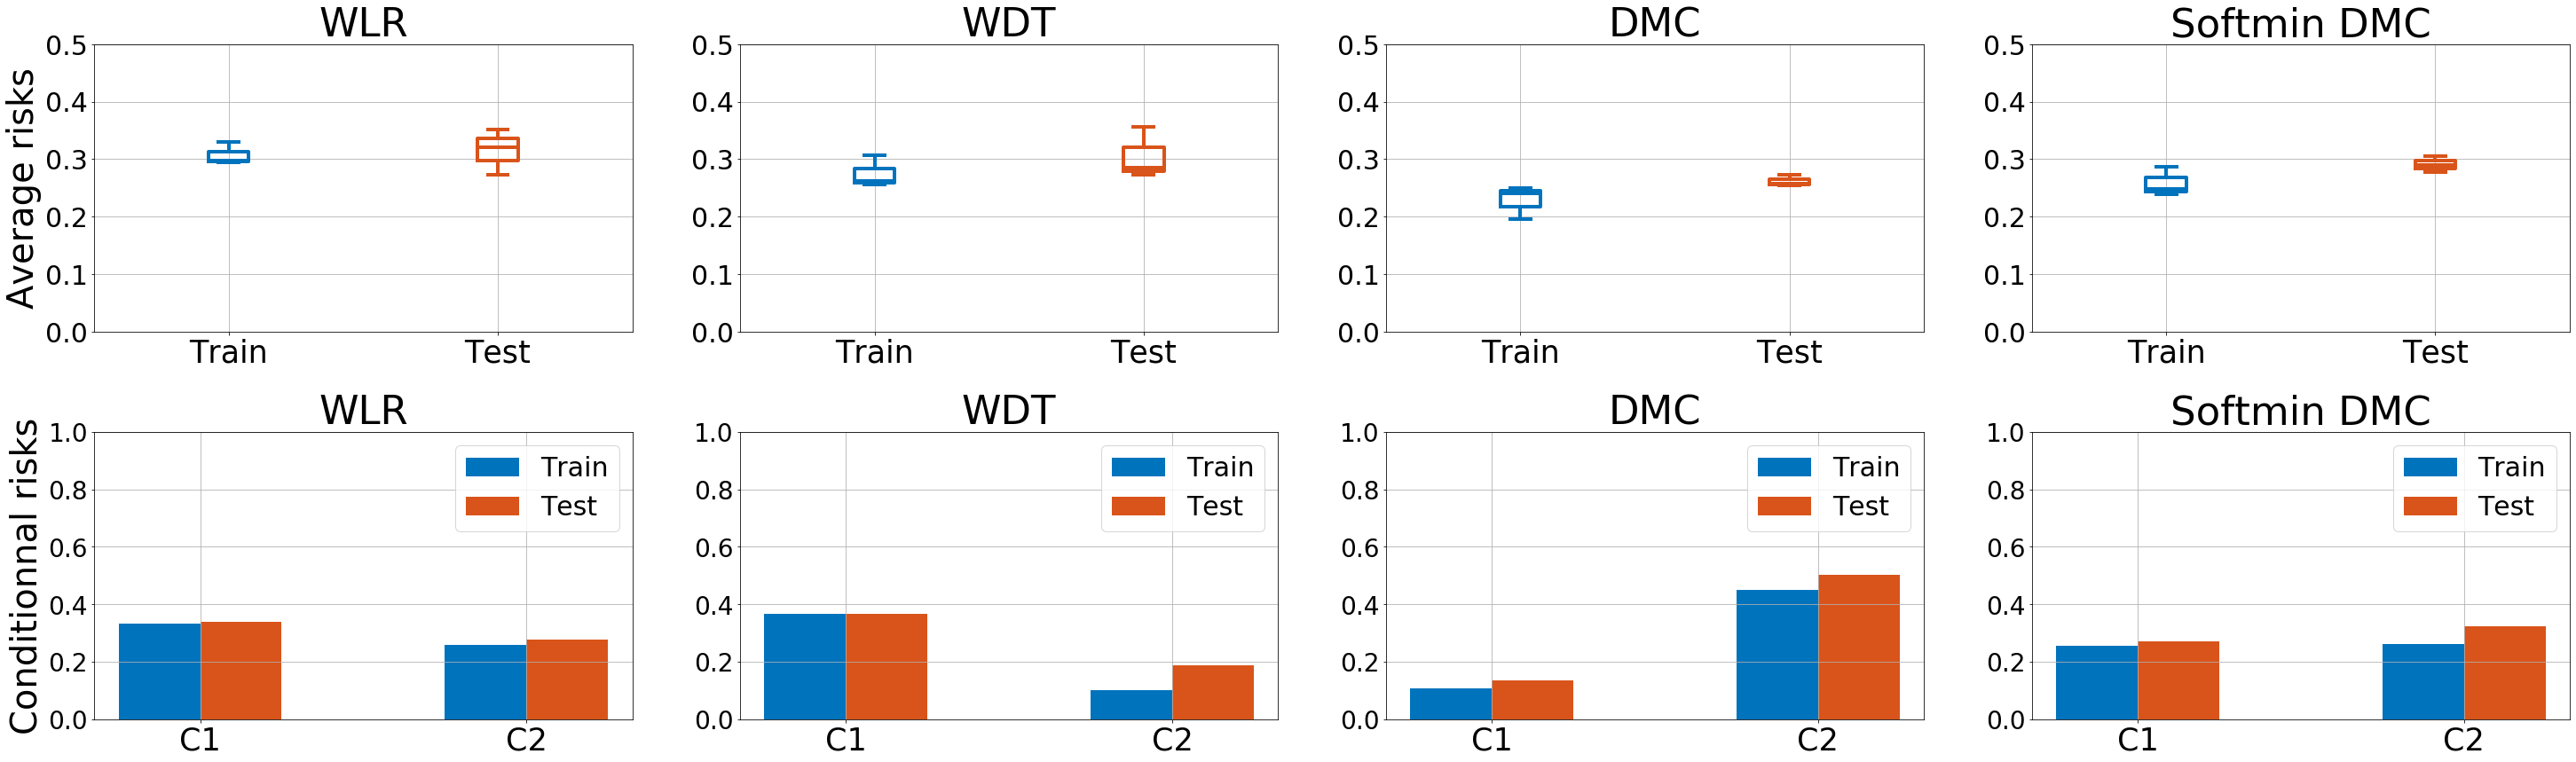

In [13]:
### Subplots conditional and global risks


fig = plt.figure(figsize=(50,14))
plt.gcf().subplots_adjust(hspace=0.35)

colors = [(0, 0.45, 0.74),(0.85, 0.33, 0.1)]

labels = []
for c in range(0, K):
    labels.append('C'+str(c+1))
    


ax1 = fig.add_subplot(2,4,1)
box_dict = ax1.boxplot([r_df.loc[np.where(r_df[['Dataset']]=='train')[0], 'risks_WLR'], r_df.loc[np.where(r_df[['Dataset']]=='test')[0], 'risks_WLR']])
for item in ['boxes', 'fliers', 'medians']:
    for sub_item,color in zip(box_dict[item], colors):
        plt.setp(sub_item, color=color, linewidth=4)
# whiskers and caps have to be treated separately since there are two of each for each plot
for item in ['whiskers', 'caps']:
    for sub_items,color in zip(zip(box_dict[item][::2],box_dict[item][1::2]),colors):
        plt.setp(sub_items, color=color, linewidth=4)
ax1.grid(b=None)
ax1.set(ylim=(0, 0.5))
ax1.grid(b=True, axis='y')
ax1.set_xticklabels(['Train', 'Test'], fontdict={'fontsize': 35, 'fontweight': 'medium'})
ax1.set_title('WLR', fontsize=45)
ax1.set_xlabel("",fontsize=30)
ax1.set_ylabel("Average risks",fontsize=40)
ax1.tick_params(axis='y', labelsize=30)


ax2 = fig.add_subplot(2,4,2)
box_dict = ax2.boxplot([r_df.loc[np.where(r_df[['Dataset']]=='train')[0], 'risks_WDT'], r_df.loc[np.where(r_df[['Dataset']]=='test')[0], 'risks_WDT']])
for item in ['boxes', 'fliers', 'medians']:
    for sub_item,color in zip(box_dict[item], colors):
        plt.setp(sub_item, color=color, linewidth=4)
# whiskers and caps have to be treated separately since there are two of each for each plot
for item in ['whiskers', 'caps']:
    for sub_items,color in zip(zip(box_dict[item][::2],box_dict[item][1::2]),colors):
        plt.setp(sub_items, color=color, linewidth=4)
ax2.grid(b=None)
ax2.set(ylim=(0, 0.5))
ax2.grid(b=True, axis='y')
ax2.set_xticklabels(['Train', 'Test'], fontdict={'fontsize': 35, 'fontweight': 'medium'})
ax2.set_title('WDT', fontsize=45)
ax2.set_xlabel("",fontsize=30)
ax2.tick_params(axis='y', labelsize=30)


ax3 = fig.add_subplot(2,4,3)
box_dict = ax3.boxplot([r_df.loc[np.where(r_df[['Dataset']]=='train')[0], 'risks_DMC'], r_df.loc[np.where(r_df[['Dataset']]=='test')[0], 'risks_DMC']])
for item in ['boxes', 'fliers', 'medians']:
    for sub_item,color in zip(box_dict[item], colors):
        plt.setp(sub_item, color=color, linewidth=4)
# whiskers and caps have to be treated separately since there are two of each for each plot
for item in ['whiskers', 'caps']:
    for sub_items,color in zip(zip(box_dict[item][::2],box_dict[item][1::2]),colors):
        plt.setp(sub_items, color=color, linewidth=4)
ax3.grid(b=None)
ax3.set(ylim=(0, 0.5))
ax3.grid(b=True, axis='y')
ax3.set_xticklabels(['Train', 'Test'], fontdict={'fontsize': 35, 'fontweight': 'medium'})
ax3.set_title('DMC', fontsize=45)
ax3.set_xlabel("",fontsize=30)
ax3.tick_params(axis='y', labelsize=30)


ax4 = fig.add_subplot(2,4,4)
box_dict = ax4.boxplot([r_df.loc[np.where(r_df[['Dataset']]=='train')[0], 'risks_SoftminDMC'], r_df.loc[np.where(r_df[['Dataset']]=='test')[0], 'risks_SoftminDMC']])
for item in ['boxes', 'fliers', 'medians']:
    for sub_item,color in zip(box_dict[item], colors):
        plt.setp(sub_item, color=color, linewidth=4)
# whiskers and caps have to be treated separately since there are two of each for each plot
for item in ['whiskers', 'caps']:
    for sub_items,color in zip(zip(box_dict[item][::2],box_dict[item][1::2]),colors):
        plt.setp(sub_items, color=color, linewidth=4)
ax4.grid(b=None)
ax4.set(ylim=(0, 0.5))
ax4.grid(b=True, axis='y')
ax4.set_xticklabels(['Train', 'Test'], fontdict={'fontsize': 35, 'fontweight': 'medium'})
ax4.set_title('Softmin DMC', fontsize=45)
ax4.set_xlabel("",fontsize=30)
ax4.tick_params(axis='y', labelsize=30)




ax5 = fig.add_subplot(2,4,5)
x = np.arange(len(labels))  
rects1 = ax5.bar(x - 0.25/2, AV_RTrain_WLR[0].tolist(), 0.25, label='Train', color=(0, 0.45, 0.74))
rects2 = ax5.bar(x + 0.25/2, AV_RTest_WLR[0].tolist(), 0.25, label='Test', color=(0.85, 0.33, 0.1))
ax5.set_xticks(x)
ax5.set_xticklabels(labels, fontdict={'fontsize': 35, 'fontweight': 'medium'})
ax5.tick_params(axis='y', labelsize=28)
ax5.yaxis.set_ticks([0,0.2,0.4,0.6,0.8,1])
ax5.set_ylabel('Conditionnal risks', fontdict={'fontsize': 40, 'fontweight': 'medium'})
ax5.legend(fontsize=30, loc='upper right')
ax5.grid(b=None)
ax5.grid(which='major', axis='y', ls='-')
ax5.set_ylim([0, 1])
ax5.set_title('WLR', fontsize=45)


ax6 = fig.add_subplot(2,4,6)
x = np.arange(len(labels))  
rects1 = ax6.bar(x - 0.25/2, AV_RTrain_WDT[0].tolist(), 0.25, label='Train', color=(0, 0.45, 0.74))
rects2 = ax6.bar(x + 0.25/2, AV_RTest_WDT[0].tolist(), 0.25, label='Test', color=(0.85, 0.33, 0.1))
ax6.set_xticks(x)
ax6.set_xticklabels(labels, fontdict={'fontsize': 35, 'fontweight': 'medium'})
ax6.tick_params(axis='y', labelsize=28)
ax6.yaxis.set_ticks([0,0.2,0.4,0.6,0.8,1])
ax6.legend(fontsize=30, loc='upper right')
ax6.grid(b=None)
ax6.grid(which='major', axis='y', ls='-')
ax6.set_ylim([0, 1])
ax6.set_title('WDT', fontsize=45)


ax7 = fig.add_subplot(2,4,7)
x = np.arange(len(labels)) 
rects1 = ax7.bar(x - 0.25/2, AV_RTrain_DMC[0].tolist(), 0.25, label='Train', color=(0, 0.45, 0.74))
rects2 = ax7.bar(x + 0.25/2, AV_RTest_DMC[0].tolist(), 0.25, label='Test', color=(0.85, 0.33, 0.1))
ax7.set_xticks(x)
ax7.set_xticklabels(labels, fontdict={'fontsize': 35, 'fontweight': 'medium'})
ax7.tick_params(axis='y', labelsize=28)
ax7.yaxis.set_ticks([0,0.2,0.4,0.6,0.8,1])
ax7.legend(fontsize=30, loc='upper right')
ax7.grid(b=None)
ax7.grid(which='major', axis='y', ls='-')
ax7.set_ylim([0, 1])
ax7.set_title('DMC', fontsize=45)


ax8 = fig.add_subplot(2,4,8)
x = np.arange(len(labels))  
rects1 = ax8.bar(x - 0.25/2, AV_RTrain_SoftminDMC[0].tolist(), 0.25, label='Train', color=(0, 0.45, 0.74))
rects2 = ax8.bar(x + 0.25/2, AV_RTest_SoftminDMC[0].tolist(), 0.25, label='Test', color=(0.85, 0.33, 0.1))
ax8.set_xticks(x)
ax8.set_xticklabels(labels, fontdict={'fontsize': 35, 'fontweight': 'medium'})
ax8.tick_params(axis='y', labelsize=28)
ax8.yaxis.set_ticks([0,0.2,0.4,0.6,0.8,1])
ax8.legend(fontsize=30, loc='upper right')
ax8.grid(b=None)
ax8.grid(which='major', axis='y', ls='-')
ax8.set_ylim([0, 1])
ax8.set_title('Softmin DMC', fontsize=45)






Display DataFrame results

In [14]:
DF_Average_risks = pd.DataFrame(columns=['Dataset', 'AVrisks_WLR', 'AVrisks_WDT', 'AVrisks_DMC', 'AVrisks_SoftminDMC'])
for i in range(nbFolds):
    DF_Average_risks.loc[0,'Dataset'] = 'Train'
    DF_Average_risks.loc[1,'Dataset'] = 'Test'
    DF_Average_risks.loc[0,'AVrisks_WLR'] = (str(format(AV_rTrain_WLR,".2f")) + " +- " + str(format(STD_rTrain_WLR,".2f")))
    DF_Average_risks.loc[1,'AVrisks_WLR'] = (str(format(AV_rTest_WLR,".2f")) + " +- " + str(format(STD_rTest_WLR,".2f")))
    DF_Average_risks.loc[0,'AVrisks_WDT'] = (str(format(AV_rTrain_WDT,".2f")) + " +- " + str(format(STD_rTrain_WDT,".2f")))
    DF_Average_risks.loc[1,'AVrisks_WDT'] = (str(format(AV_rTest_WDT,".2f")) + " +- " + str(format(STD_rTest_WDT,".2f")))
    DF_Average_risks.loc[0,'AVrisks_DMC'] = (str(format(AV_rTrain_DMC,".2f")) + " +- " + str(format(STD_rTrain_DMC,".2f")))
    DF_Average_risks.loc[1,'AVrisks_DMC'] = (str(format(AV_rTest_DMC,".2f")) + " +- " + str(format(STD_rTest_DMC,".2f")))
    DF_Average_risks.loc[0,'AVrisks_SoftminDMC'] = (str(format(AV_rTrain_SoftminDMC,".2f")) + " +- " + str(format(STD_rTrain_SoftminDMC,".2f")))
    DF_Average_risks.loc[1,'AVrisks_SoftminDMC'] = (str(format(AV_rTest_SoftminDMC,".2f")) + " +- " + str(format(STD_rTest_SoftminDMC,".2f")))
DF_Average_risks = DF_Average_risks.reset_index()
DF_Average_risks.drop(['index'], axis='columns', inplace=True)



DF_max_condRisks = pd.DataFrame(columns=['Dataset', 'MaxCond_WLR', 'MaxCond_WDT', 'MaxCond_DMC', 'MaxCond_SoftminDMC'])
for i in range(nbFolds):
    DF_max_condRisks.loc[0,'Dataset'] = 'Train'
    DF_max_condRisks.loc[1,'Dataset'] = 'Test'
    DF_max_condRisks.loc[0,'MaxCond_WLR'] = (str(format(AV_RmaxTrain_WLR,".2f")) + " +- " + str(format(STD_RmaxTrain_WLR,".2f")))
    DF_max_condRisks.loc[1,'MaxCond_WLR'] = (str(format(AV_RmaxTest_WLR,".2f")) + " +- " + str(format(STD_RmaxTest_WLR,".2f")))
    DF_max_condRisks.loc[0,'MaxCond_WDT'] = (str(format(AV_RmaxTrain_WDT,".2f")) + " +- " + str(format(STD_RmaxTrain_WDT,".2f")))
    DF_max_condRisks.loc[1,'MaxCond_WDT'] = (str(format(AV_RmaxTest_WDT,".2f")) + " +- " + str(format(STD_RmaxTest_WDT,".2f")))
    DF_max_condRisks.loc[0,'MaxCond_DMC'] = (str(format(AV_RmaxTrain_DMC,".2f")) + " +- " + str(format(STD_RmaxTrain_DMC,".2f")))
    DF_max_condRisks.loc[1,'MaxCond_DMC'] = (str(format(AV_RmaxTest_DMC,".2f")) + " +- " + str(format(STD_RmaxTest_DMC,".2f")))
    DF_max_condRisks.loc[0,'MaxCond_SoftminDMC'] = (str(format(AV_RmaxTrain_SoftminDMC,".2f")) + " +- " + str(format(STD_RmaxTrain_SoftminDMC,".2f")))
    DF_max_condRisks.loc[1,'MaxCond_SoftminDMC'] = (str(format(AV_RmaxTest_SoftminDMC,".2f")) + " +- " + str(format(STD_RmaxTest_SoftminDMC,".2f")))
DF_max_condRisks = DF_max_condRisks.reset_index()
DF_max_condRisks.drop(['index'], axis='columns', inplace=True)



DF_psi_condRisks = pd.DataFrame(columns=['Dataset', 'psi_WLR', 'psi_WDT', 'psi_DMC', 'psi_SoftminDMC'])
for i in range(nbFolds):
    DF_psi_condRisks.loc[0,'Dataset'] = 'Train'
    DF_psi_condRisks.loc[1,'Dataset'] = 'Test'
    DF_psi_condRisks.loc[0,'psi_WLR'] = (str(format(AV_psi_Train_WLR,".2f")) + " +- " + str(format(STD_psi_Train_WLR,".2f")))
    DF_psi_condRisks.loc[1,'psi_WLR'] = (str(format(AV_psi_Test_WLR,".2f")) + " +- " + str(format(STD_psi_Test_WLR,".2f")))
    DF_psi_condRisks.loc[0,'psi_WDT'] = (str(format(AV_psi_Train_WDT,".2f")) + " +- " + str(format(STD_psi_Train_WDT,".2f")))
    DF_psi_condRisks.loc[1,'psi_WDT'] = (str(format(AV_psi_Test_WDT,".2f")) + " +- " + str(format(STD_psi_Test_WDT,".2f")))
    DF_psi_condRisks.loc[0,'psi_DMC'] = (str(format(AV_psi_Train_DMC,".2f")) + " +- " + str(format(STD_psi_Train_DMC,".2f")))
    DF_psi_condRisks.loc[1,'psi_DMC'] = (str(format(AV_psi_Test_DMC,".2f")) + " +- " + str(format(STD_psi_Test_DMC,".2f")))
    DF_psi_condRisks.loc[0,'psi_SoftminDMC'] = (str(format(AV_psi_Train_SoftminDMC,".2f")) + " +- " + str(format(STD_psi_Train_SoftminDMC,".2f")))
    DF_psi_condRisks.loc[1,'psi_SoftminDMC'] = (str(format(AV_psi_Test_SoftminDMC,".2f")) + " +- " + str(format(STD_psi_Test_SoftminDMC,".2f")))
DF_psi_condRisks = DF_psi_condRisks.reset_index()
DF_psi_condRisks.drop(['index'], axis='columns', inplace=True)



In [15]:
DF_Average_risks

,Dataset,AVrisks_WLR,AVrisks_WDT,AVrisks_DMC,AVrisks_SoftminDMC
0,Train,0.31 +- 0.02,0.27 +- 0.02,0.23 +- 0.02,0.26 +- 0.02
1,Test,0.32 +- 0.03,0.30 +- 0.04,0.26 +- 0.01,0.29 +- 0.01


In [16]:
DF_max_condRisks

,Dataset,MaxCond_WLR,MaxCond_WDT,MaxCond_DMC,MaxCond_SoftminDMC
0,Train,0.33 +- 0.02,0.37 +- 0.04,0.45 +- 0.09,0.26 +- 0.02
1,Test,0.35 +- 0.02,0.37 +- 0.03,0.50 +- 0.04,0.32 +- 0.01


In [17]:
DF_psi_condRisks

,Dataset,psi_WLR,psi_WDT,psi_DMC,psi_SoftminDMC
0,Train,0.08 +- 0.03,0.27 +- 0.06,0.34 +- 0.10,0.01 +- 0.01
1,Test,0.10 +- 0.05,0.18 +- 0.05,0.37 +- 0.06,0.05 +- 0.01
